In [1]:
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import matplotlib
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os
import numpy as np

from statsmodels.tsa.seasonal import STL
%matplotlib inline

init_notebook_mode(connected = True)

In [62]:
if os.path.exists('./city_temperature.csv'):
    df = pd.read_csv('./city_temperature.csv',low_memory=False)
    df['Date'] = pd.to_datetime(df.loc[:,'Month':'Year'],dayfirst=True,errors='coerce')

In [63]:
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature,Date
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2,1995-01-01
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4,1995-01-02
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8,1995-01-03
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4,1995-01-04
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9,1995-01-05


In [64]:
df.describe()

,Month,Day,Year,AvgTemperature
count,2.906327e+06,2.906327e+06,2.906327e+06,2.906327e+06
mean,6.469163e+00,1.571682e+01,2.006624e+03,5.600492e+01
std,3.456489e+00,8.800534e+00,2.338226e+01,3.212359e+01
min,1.000000e+00,0.000000e+00,2.000000e+02,-9.900000e+01
25%,3.000000e+00,8.000000e+00,2.001000e+03,4.580000e+01
50%,6.000000e+00,1.600000e+01,2.007000e+03,6.250000e+01
75%,9.000000e+00,2.300000e+01,2.013000e+03,7.550000e+01
max,1.200000e+01,3.100000e+01,2.020000e+03,1.100000e+02


In [70]:
print(f"Number of unique Countries: {len(df.Country.unique())}")
print(f"Number of unique Cities: {len(df.City.unique())} ")

Number of unique Countries: 125
Number of unique Cities: 321 


## US: 3 Month Plot & Auto Correlation

In [3]:
df_us_3m = df[df['Country']=='US'].groupby([pd.Grouper(key='Date',freq='3M')]).mean().unstack(level=0).reindex().AvgTemperature
df_us_3m.where(df_us_3m>-99,inplace=True)

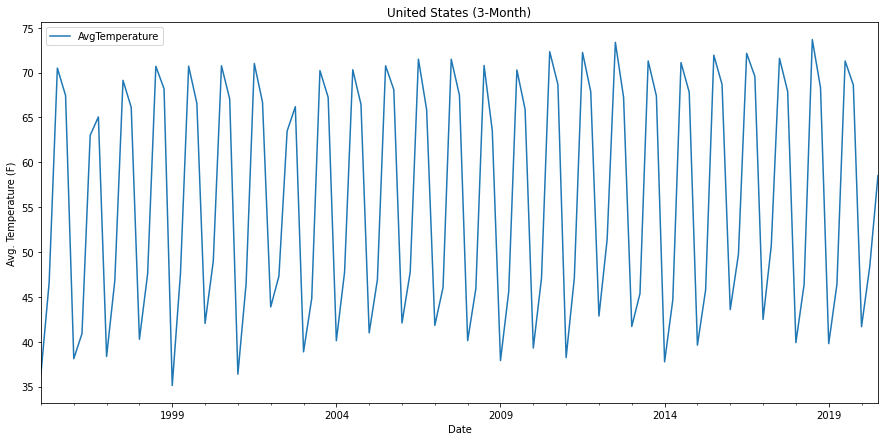

In [4]:
df_us_3m.interpolate(method='time',inplace=True)
df_us_3m.plot(title='United States (3-Month)',figsize=(15,7),label='AvgTemperature')
plt.ylabel('Avg. Temperature (F)')
plt.legend()
plt.savefig('./Images/US/us_3m_plot.jpeg')

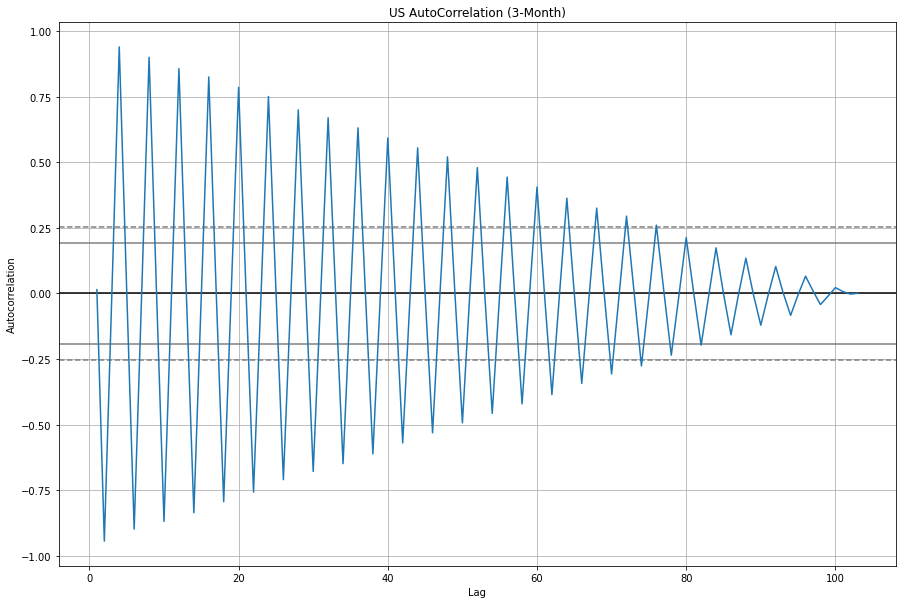

In [5]:
fig,ax=plt.subplots(figsize=(15,10))
pd.plotting.autocorrelation_plot(df_us_3m,ax=ax)
plt.title('US AutoCorrelation (3-Month)')
plt.savefig('./Images/US/us_autocorr_3m.jpeg')

In [6]:
df_us_m = df[df['Country']=='US'].groupby([pd.Grouper(key='Date',freq='M')]).mean().unstack(level=0).reindex().AvgTemperature
df_us_m.where(df_us_m>-99,inplace=True)

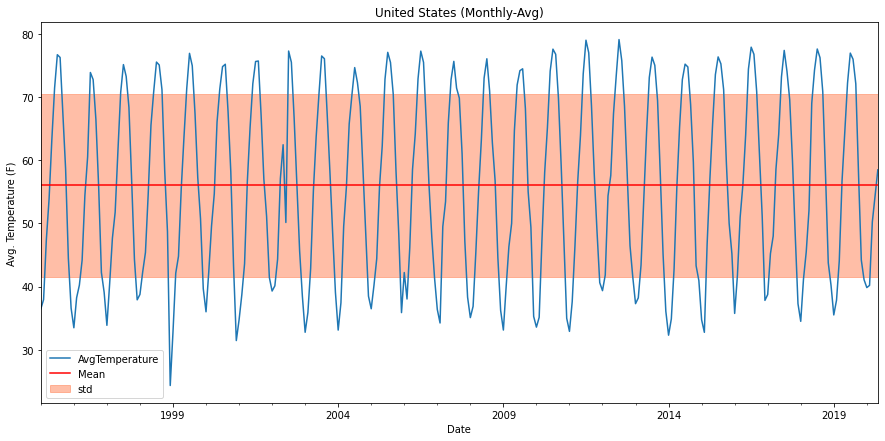

In [7]:
df_us_m.interpolate(method='time',inplace=True)
df_us_m.plot(title='United States (Monthly-Avg)',figsize=(15,7),label='AvgTemperature')
plt.axhline(df_us_m.mean(),color='r',label='Mean')
plt.axhspan(df_us_m.mean()-df_us_m.std(),df_us_m.mean()+df_us_m.std(),alpha=0.5,color='coral',label='std')
plt.ylabel('Avg. Temperature (F)')
plt.legend()
plt.savefig('./Images/US/us_1m_plot.jpeg')

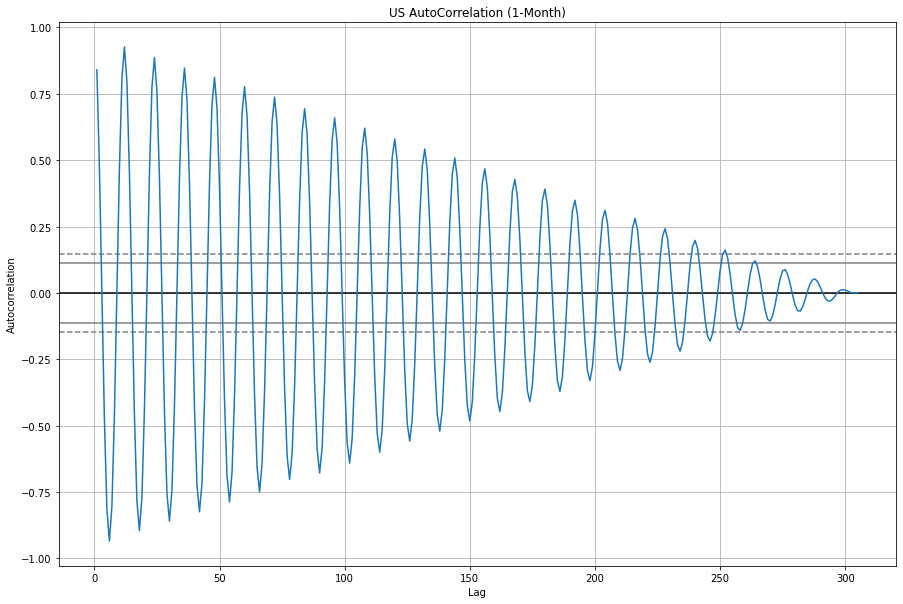

In [8]:
fig2,ax2=plt.subplots(figsize=(15,10))
pd.plotting.autocorrelation_plot(df_us_m,ax=ax2)
plt.title('US AutoCorrelation (1-Month)')
plt.savefig('./Images/US/us_autocorr_1m.jpeg')

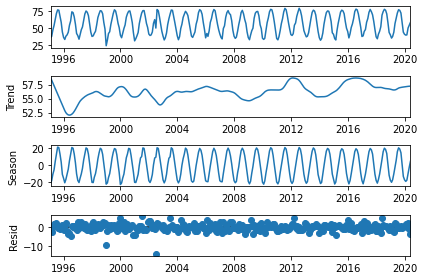

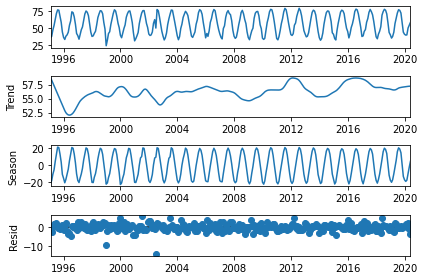

In [9]:
model = STL(df_us_m).fit()
model.plot()

In [10]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [11]:
arm = ARIMA(df_us_m,order=(1,0,7)).fit()

In [12]:
arm.pvalues

const     0.000000e+00
ar.L1     2.282760e-11
ma.L1     1.711179e-06
ma.L2     5.593830e-04
ma.L3     1.432121e-01
ma.L4     1.092150e-07
ma.L5     5.959428e-14
ma.L6     3.786123e-14
ma.L7     1.667279e-04
sigma2    7.536392e-56
dtype: float64

Text(0.5, 1.0, 'US AutoCorrelation (Month)')

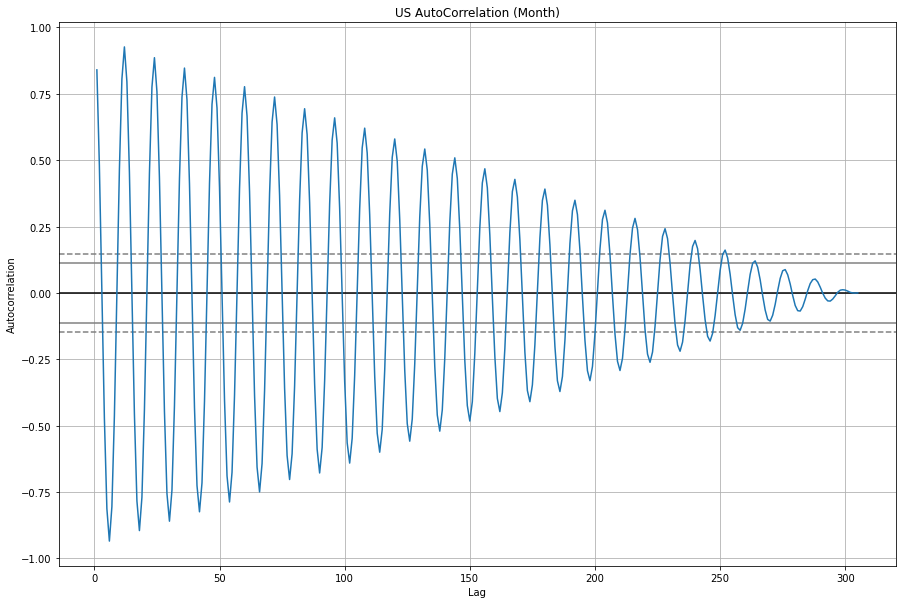

In [13]:
fig,ax=plt.subplots(figsize=(15,10))
pd.plotting.autocorrelation_plot(df_us_m,ax=ax)
plt.title('US AutoCorrelation (Month)')

In [14]:
y_hat = arm.predict()

In [15]:
y_hat

Date
1995-01-31    56.180045
1995-02-28    39.930342
1995-03-31    43.921700
1995-04-30    55.650283
1995-05-31    60.324835
                ...    
2020-01-31    39.211887
2020-02-29    43.967561
2020-03-31    46.537605
2020-04-30    56.338258
2020-05-31    57.509022
Freq: M, Name: predicted_mean, Length: 305, dtype: float64

Text(0.5, 1.0, 'Actual vs. Predict (United States - Month)')

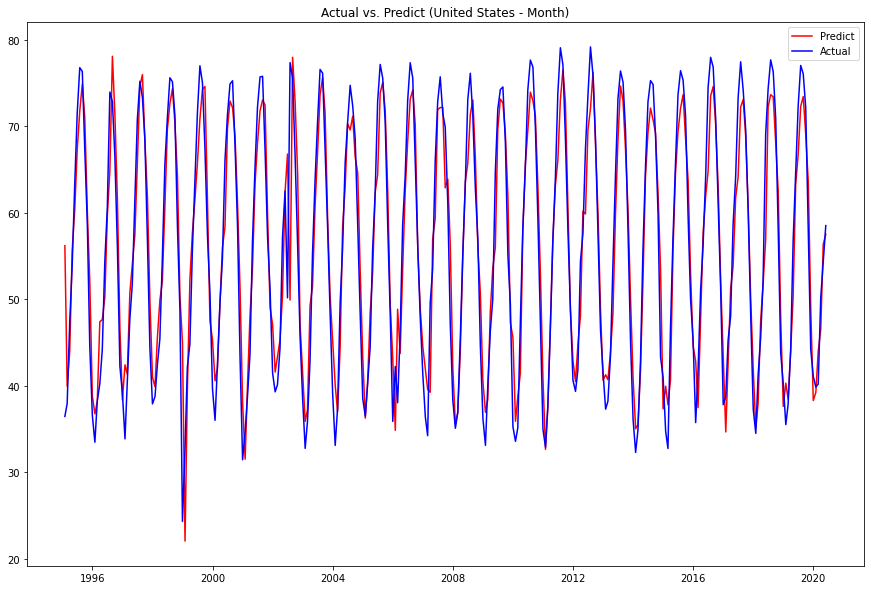

In [16]:
fig2,ax2=plt.subplots(figsize=(15,10))
plt.plot(y_hat,'r',axes=ax2,label='Predict')
plt.plot(df_us_m,'b',axes=ax2,label='Actual')
plt.legend()
plt.title('Actual vs. Predict (United States - Month)')

In [17]:
np.linalg.norm(y_hat-df_us_m)/df_us_m.size

0.2763113697094579

In [18]:
df_us_d = df[df['Country']=='US'].groupby([pd.Grouper(key='Date',freq='D')]).mean().unstack(level=0).reindex().AvgTemperature
df_us_d.where(df_us_d>-99,inplace=True)

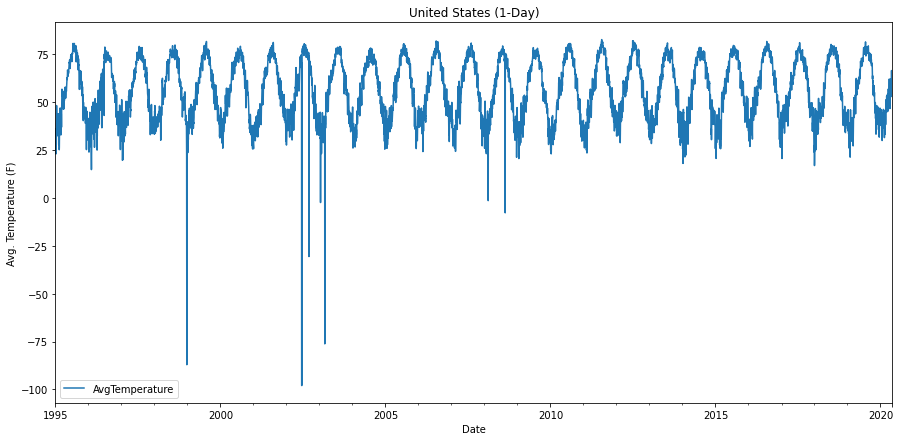

In [19]:
df_us_d.interpolate(method='time',inplace=True)
df_us_d.plot(title='United States (1-Day)',figsize=(15,7),label='AvgTemperature')
plt.ylabel('Avg. Temperature (F)')
plt.legend()
plt.savefig('./Images/US/us_1d_plot.jpeg')

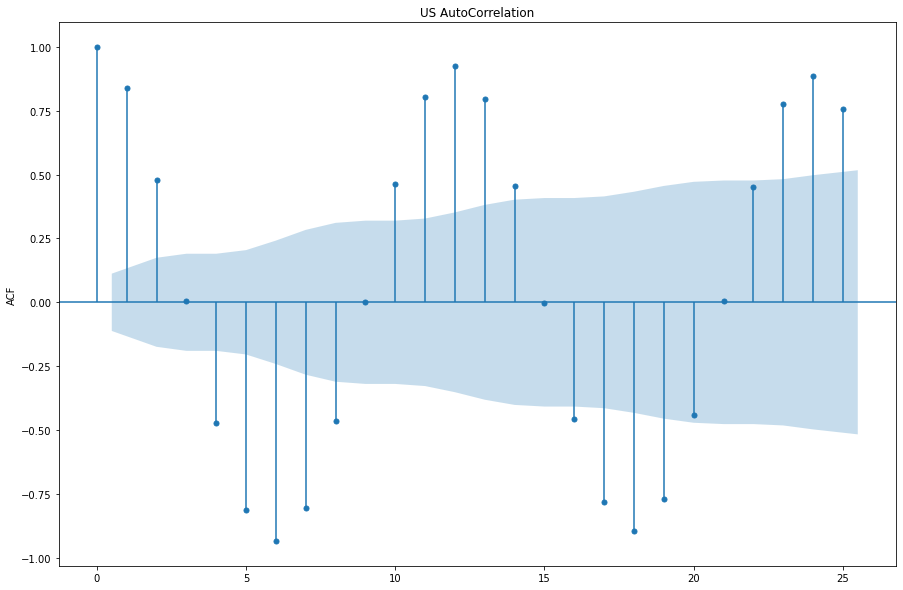

In [20]:
fig,ax=plt.subplots(figsize=(15,10))
plot_acf(df_us_m,ax=ax)
plt.title('US AutoCorrelation')
plt.ylabel('ACF')
plt.savefig('./Images/US/acf_us.jpeg')

## PACF

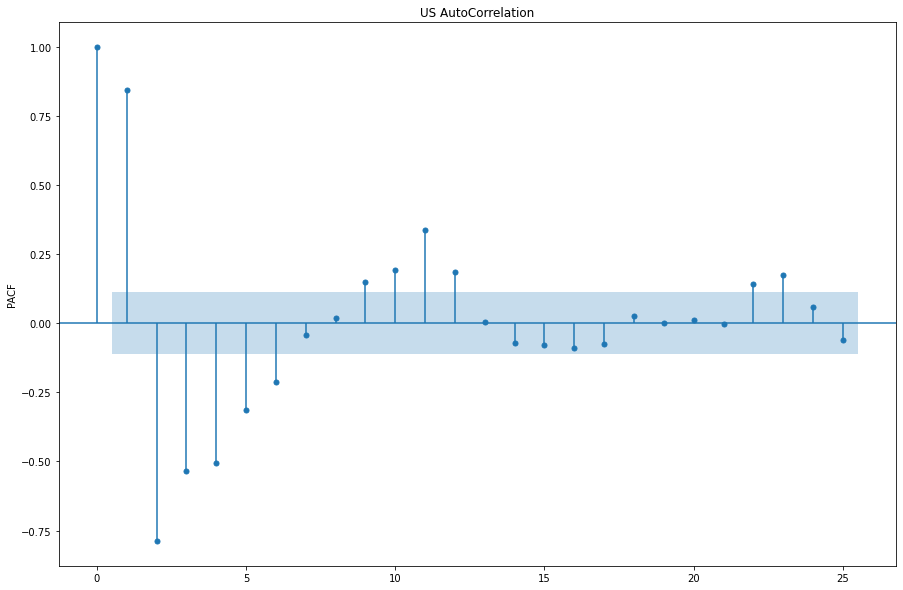

In [57]:
fig,ax=plt.subplots(figsize=(15,10))
plot_pacf(df_us_m,ax=ax)
plt.title('US AutoCorrelation')
plt.ylabel('PACF')
plt.savefig('./Images/US/pacf_us.jpeg')

In [22]:
df_us_d.autocorr(lag=1)

0.955304627517584

In [47]:
arm = ARIMA(df_us_m.iloc[1:-25],order=(7,0,1)).fit()

In [52]:
arm.pvalues

const     0.000000e+00
ar.L1     7.394583e-01
ar.L2     9.735111e-01
ar.L3     7.699281e-01
ar.L4     1.971251e-05
ar.L5     6.421253e-01
ar.L6     4.704338e-01
ar.L7     8.188060e-01
ma.L1     9.516135e-01
sigma2    3.244923e-81
dtype: float64

In [38]:
y_hat = arm.predict()
test = arm.get_prediction(start=-25).predicted_mean

Text(0.5, 1.0, 'Actual vs. Predict (United States)')

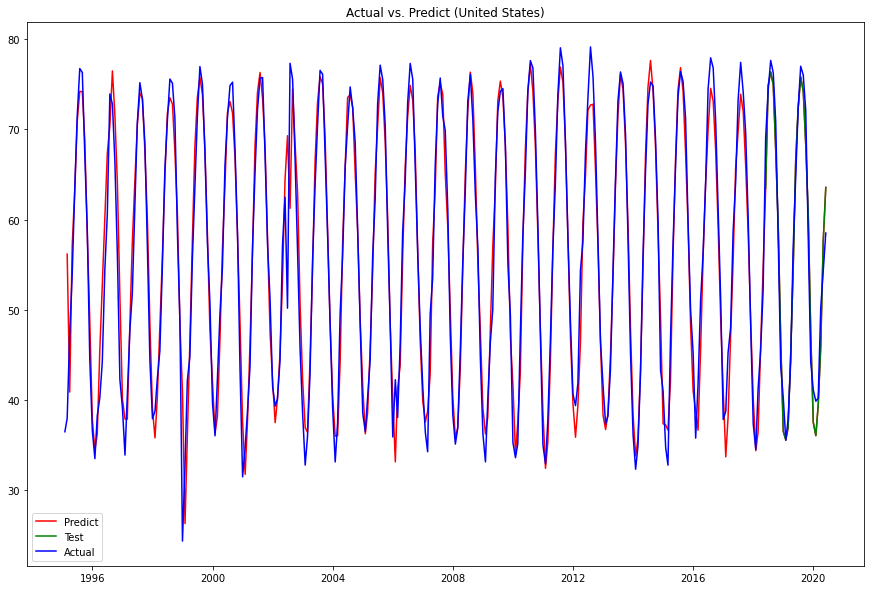

In [39]:
fig2,ax2=plt.subplots(figsize=(15,10))
plt.plot(y_hat,'r',axes=ax2,label='Predict')
plt.plot(test,'g',axes=ax2,label='Test')
plt.plot(df_us_m,'b',axes=ax2,label='Actual')
plt.legend()
plt.title('Actual vs. Predict (United States)')

In [27]:
# np.linalg.norm(y_hat-df_us_m)/df_us_m.size
np.linalg.norm(test-df_us_m.iloc[-25:])#/len(df_us_m.iloc[-25:])

nan

In [40]:
arm.fittedvalues

Date
1995-02-28    56.167801
1995-03-31    40.850010
1995-04-30    57.081347
1995-05-31    63.173687
1995-06-30    70.867515
                ...    
2020-01-31    36.006937
2020-02-29    39.416873
2020-03-31    45.986411
2020-04-30    57.601781
2020-05-31    63.571152
Freq: M, Length: 304, dtype: float64

In [49]:
f = arm.forecast(25)

In [50]:
f

2018-05-31    63.352618
2018-06-30    71.295731
2018-07-31    74.758032
2018-08-31    73.242015
2018-09-30    67.297929
2018-10-31    58.715070
2018-11-30    49.354863
2018-12-31    41.829117
2019-01-31    38.263980
2019-02-28    39.465881
2019-03-31    45.050056
2019-04-30    53.485996
2019-05-31    62.517630
2019-06-30    69.756605
2019-07-31    73.294082
2019-08-31    72.237433
2019-09-30    66.925964
2019-10-31    58.815712
2019-11-30    50.086407
2019-12-31    43.055779
2020-01-31    39.565213
2020-02-29    40.497176
2020-03-31    45.552012
2020-04-30    53.342351
2020-05-31    61.773372
Freq: M, Name: predicted_mean, dtype: float64

In [51]:
np.linalg.norm(f-df_us_m[-25:])/df_us_m.size

0.053784487172150224